In [2]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph
import numpy as np

In [3]:
from littlegrad2.engine import Tensor

In [4]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR', showGrads=True):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        #dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record') # original karpathy version, my version below
        lerbelArr = np.atleast_2d(np.squeeze(n.grad)) if showGrads else np.atleast_2d(np.squeeze(n.data))
        lerbel = "{{"
        for row in lerbelArr:
            lerbel += "{" + np.array2string(row, separator = '|', precision = 2, suppress_small = True) + "}|"
        lerbel = lerbel[:-1] + "}}"
        dot.node(name=str(id(n)), label = lerbel, shape = 'record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
# a very simple example
x = Tensor(1.0)
y = (x * 2 + 1).relu()
y.backprop()
draw_dot(y)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [6]:
#my own test for incest cases (child and parent making child nodes)
a = Tensor(-4.0)
b = Tensor(2.0)
c = a + b
c += c * 1

c.backprop()
draw_dot(c)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

NEW TOPO SORT (worked cuz it can detect and avoid incest cases):
        nodeList = []
        visitedNodes = set()

        def getNodes(val):
            if val not in visitedNodes:
                for child in val.children:
                    getNodes(child)
                nodeList.append(val)
                visitedNodes.add(val)
        getNodes(self)
        visitedNodes.reverse()

OLD TOPO SORT (didn't work, couldn't identify or avoid incest cases):
        childList = []
        def getChildren(val):
            if val not in childList:
                childList.append(val)
                for child in val.children:
                    getChildren(child)
        getChildren(self)

In [7]:
#my own test for correct neg() bookeeping
a = Tensor(-4.0)
b = Tensor(2.0)
c = a
c += 1 + c + (-a)
c.backprop()
draw_dot(c)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [8]:
x = Tensor([-4.0, -4.0])
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backprop()
draw_dot(y)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [9]:
a = Tensor(-4.0)
b = Tensor(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
g.backprop()
draw_dot(g)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [10]:
# a simple 2D neuron
import random
random.seed(1337)
#n = nn.Neuron(2)
#x = [Tensor(1.0), Tensor(-2.0)]
#y = n(x)
#y.backprop()

n = np.array([Tensor(random.uniform(-1, 1)), Tensor(random.uniform(-1, 1))])
x = [Tensor(1.0), Tensor(-2.0)]
y = n.dot([t.relu() for t in x])
y.backprop()

dot = draw_dot(y)
dot

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [11]:
random.seed(1337)
n = Tensor([random.uniform(-1, 1), random.uniform(-1, 1)])
x = Tensor([1, -2])
y = n.relu() @ (x.relu().transpose())
y.backprop()

dot = draw_dot(y)
dot

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [12]:
# a = Tensor(np.array([[[[10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0]]],
                     
#                      [[[0, 0, 0, 10, 10, 10],
#                      [0, 0, 0, 10, 10, 10],
#                      [0, 0, 0, 10, 10, 10],
#                      [0, 0, 0, 10, 10, 10],
#                      [0, 0, 0, 10, 10, 10],
#                      [0, 0, 0, 10, 10, 10]]]]))

# b = Tensor(np.array([[[[1, 0, -1],
#                      [1, 0, -1],
#                      [1, 0, -1]]],
#                      [[[-1, 0, 1],
#                      [-1, 0, 1],
#                      [-1, 0, 1]]]]))

a = Tensor(np.array([[[[10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0]]]]))

b = Tensor(np.array([[[[1, 0, -1],
                     [1, 0, -1],
                     [1, 0, -1]]]]))

#a = Tensor(np.array([[[[1, 2, 3]], [[2, 4, 6]]]]))
#b = Tensor(np.array([[[[0, 1, 0.5]], [[0, 2, 1]]]]))

print('a: ', a.data.shape, '\n', a.data.real)
print('b: ', b.data.shape, '\n', b.data.real)

#(m, nc, nx, ny) = a.data.shape
#(fn, fc, fx, fy) = b.data.shape

#y = a.reshape(a.data.shape).conv(b).relu().avgPool().flatten()
y = a.conv(b)
print('y: ', y.data.shape, '\n', np.round(y.data.real, 2))
y.backprop()

dot = draw_dot(y, showGrads=False)
#dot = draw_dot(y)
dot

a:  (1, 1, 6, 6) 
 [[[[10. 10. 10.  0.  0.  0.]
   [10. 10. 10.  0.  0.  0.]
   [10. 10. 10.  0.  0.  0.]
   [10. 10. 10.  0.  0.  0.]
   [10. 10. 10.  0.  0.  0.]
   [10. 10. 10.  0.  0.  0.]]]]
b:  (1, 1, 3, 3) 
 [[[[ 1.  0. -1.]
   [ 1.  0. -1.]
   [ 1.  0. -1.]]]]
y:  (1, 1, 4, 4) 
 [[[[ 0. 30. 30. -0.]
   [ 0. 30. 30. -0.]
   [ 0. 30. 30. -0.]
   [ 0. 30. 30. -0.]]]]


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [31]:
# a = Tensor(np.array([[[10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0]]]))
a = Tensor(np.array([[[[10, 10, 10, 0, 0, 0],
                     [10, 20, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 20],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 20],
                     [20, 10, 10, 0, 0, 0]]]]))

a = Tensor(np.array([[[[10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0]]],
                     
                     [[[0, 0, 0, 10, 10, 10],
                     [0, 0, 0, 10, 10, 10],
                     [0, 0, 0, 10, 10, 10],
                     [0, 0, 0, 10, 10, 10],
                     [0, 0, 0, 10, 10, 10],
                     [0, 0, 0, 10, 10, 10]]],
                     
                     [[[10, 10, 10, 0, 0, 0],
                     [10, 20, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 20],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 20],
                     [20, 10, 10, 0, 0, 0]]]]))

b = Tensor(np.arange(4).reshape((1, 2, 2)))

b = Tensor(np.array([[[[1, 0, -1],
                     [1, 0, -1],
                     [1, 0, -1]]]]))

#print(np.array(a.data.shape), np.array(b.data.shape))
# dimLen = len(a.data.shape)
# bPadded = np.pad(b.data, np.split(np.insert(np.array(a.data.shape) - np.array(b.data.shape), slice(0, dimLen, 1), 0), dimLen))
# print(bPadded)
# bSlice = tuple([slice(i) for i in b.data.shape])
# print(bSlice)
# bUnpadded = bPadded[bSlice]
# print(bUnpadded)
# print(bUnpadded.shape)

stride, filter_size = 2, 2
# aSplit = [np.split(aPiece, np.ceil(a.data.shape[-1] / stride), axis = -1) for aPiece in np.split(a.data, np.ceil(a.data.shape[-2] / stride), axis = -2)]
# for row in aSplit:
#     for i in range(len(row)):
#         row[i] = row[i].flatten()[np.argmax(row[i])] # item.flatten().slice(np.argmax(item))
# print(a.data)
# aSplit = np.array(aSplit)

#aSplit = [np.split(aPiece, np.ceil(a.data.shape[-1] / stride), axis = -1) for aPiece in np.split(a.data, np.ceil(a.data.shape[-2] / stride), axis = -2)]

# aSplit = []
# for row in np.split(a.data, np.ceil(a.data.shape[-2] / stride), axis = -2):
#     aSplit.append([np.max(i) for i in np.split(row, np.ceil(a.data.shape[-1] / stride), axis = -1)])
# aSplit = np.array(aSplit)
# print(aSplit)

# (m, nc, nx, ny) = a.data.shape
# aSplit = np.ndarray((m, nc, int(np.ceil(nx/stride)), int(np.ceil(ny/stride))))
# maxIndices = np.ndarray((4, m, nc, int(np.ceil(nx/stride)), int(np.ceil(ny/stride))), dtype = int)
# for x in range(aSplit.shape[-2]):
#     for y in range(aSplit.shape[-1]):
#         xSlice = slice(stride*(x), stride*(x+1)) if stride*(x+1) <= nx else slice(stride*(x), aSplit.shape[-2])
#         ySlice = slice(stride*(y), stride*(y+1)) if stride*(y+1) <= ny else slice(stride*(y), aSplit.shape[-1])
#         maxIndices[-2, ..., x, y] = np.argmax(np.max(a.data[..., xSlice, ySlice], axis = -1), axis = -1) + (x*filter_size)
#         maxIndices[-1, ..., x, y] = np.argmax(np.max(a.data[..., xSlice, ySlice], axis = -2), axis = -1) + (y*filter_size)
# np.copyto(dst = maxIndices[0], src = np.arange(m).reshape((m, 1, 1, 1)))
# np.copyto(dst = maxIndices[1], src = np.arange(nc).reshape((1, nc, 1, 1)))
# print(a.data.real[maxIndices[0], maxIndices[1], maxIndices[2], maxIndices[3]])

#a = Tensor(np.array([[[[1, 2, 3]], [[2, 4, 6]]]]))
#b = Tensor(np.array([[[[0, 1, 0.5]], [[0, 2, 1]]]]))
(m, nc, nx, ny) = a.data.shape
(fn, fc, fx, fy) = b.data.shape
print('a: ', a.data.shape, '\n', a.data)
print('b: ', b.data.shape, '\n', b.data)

# axes, pad_width_tuple = (2, 3, 4), ((0, 0), (0, 0), (0, 0), (0, nx-fx), (0, ny-fy))
# selfData =  np.fft.fftn(a.data.reshape((m, 1, nc, nx, ny)), axes = axes)
# otherData = np.fft.fftn(np.pad(np.flip(b.data.reshape((1, fn, fc, fx, fy)), axes), pad_width_tuple), axes = axes)
# out = np.fft.ifftn(selfData * otherData, axes = axes).real[:, :, -1, fx-1:nx, fy-1:ny]

# DEPTHWISE CONVOLUTION:
pad_width_tuple = ((0, 0), (0, 0), (0, 0), (0, nx-fx), (0, ny-fy))
selfData =  np.fft.fftn(a.data.reshape((m, 1, nc, nx, ny)), axes = (-2, -1))
otherData = np.fft.fftn(np.pad(np.flip(b.data.reshape((1, fn, fc, fx, fy)), (-2, -1)), pad_width_tuple), axes = (-2, -1))
out = np.fft.ifftn(selfData * otherData, axes = (-2, -1)).real[:, :, -1, fx-1:nx, fy-1:ny]

print('out: ', out.shape, '\n', np.round(out))

# POINTWISE CONVOLUTION:
# test = np.tile(np.array([1, 2-1j, -1j, -1+2j]).reshape((-1, 1, 1)), (1, 2, 2))
# print('test: ', test.shape, '\n', test)
# print('fft(test): \n', np.fft.fftn(test, axes = (0,)))

#print(a.maxPool2d().data)

a:  (3, 1, 6, 6) 
 [[[[10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]]]


 [[[ 0.+0.j  0.+0.j  0.+0.j 10.+0.j 10.+0.j 10.+0.j]
   [ 0.+0.j  0.+0.j  0.+0.j 10.+0.j 10.+0.j 10.+0.j]
   [ 0.+0.j  0.+0.j  0.+0.j 10.+0.j 10.+0.j 10.+0.j]
   [ 0.+0.j  0.+0.j  0.+0.j 10.+0.j 10.+0.j 10.+0.j]
   [ 0.+0.j  0.+0.j  0.+0.j 10.+0.j 10.+0.j 10.+0.j]
   [ 0.+0.j  0.+0.j  0.+0.j 10.+0.j 10.+0.j 10.+0.j]]]


 [[[10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 20.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j 20.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
   [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j 20.+0.j]
   [20.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]]]]
b:  (1, 1, 3, 3)

In [14]:
dot.render('gout')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

y:  (1, 1, 1, 3) 
 [[[[1.5 2.5 3.5]]]]
a.grad:  (1, 1, 3) 
 [[[1.+0.j 1.+0.j 1.+0.j]]]
b.grad:  (1, 1, 1, 1) 
 [[[[1.+0.j]]]]


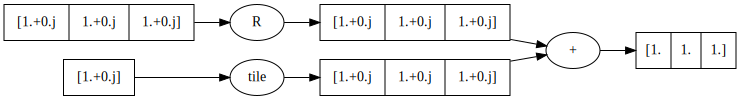

In [ ]:
a = Tensor(np.array([[[1., 2., 3.]]]))
b = Tensor(np.array([[[[0.5]]]]))

y = a + b
print('y: ', y.data.shape, '\n', np.round(y.data.real, 2))
y.backprop()

print('a.grad: ', a.grad.shape, '\n', a.grad)
print('b.grad: ', b.grad.shape, '\n', b.grad)

dot = draw_dot(y)
dot